In [2]:
import numpy as np
import pandas as pd
import hdbscan

from collections import Counter
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_pickle('../../data/processed/state2/right_ios_df.pkl')
print(df.shape)

(13533, 8)


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(X_scaled, columns=df.columns)

In [5]:
def calculate_gini_score(labels):
    counts = Counter(labels)
    if -1 in counts:
        del counts[-1]
    if len(counts) < 2:
        return 0.0 
    y = np.array(sorted(counts.values()))
    n = len(y)
    numerator = sum((2 * (i + 1) - n - 1) * y[i] for i in range(n))
    denominator = n * sum(y)

    gini = numerator / denominator
    
    return gini

In [6]:
results_list = []

In [7]:
# k means model

# possible k values
for k in [2, 3, 4, 5]:
    kmeans_final = KMeans(n_clusters=k, random_state=42)
    kmeans_final.fit(scaled_df)
    final_labels = kmeans_final.labels_

    sil_score = silhouette_score(scaled_df, final_labels)
    noise_percentage = 0.0
    gini_score = calculate_gini_score(final_labels)

    results_list.append({
        'model': 'kmeans',
        'sil. #': sil_score,
        'Gini': gini_score,
        'noise %': noise_percentage,
        'clust. #': k
    })    


In [8]:
N_total = X_scaled.shape[0]

In [9]:
# DBSCAN modeling
for eps in np.linspace(0.1, 2.0, 20):
    for min_pts in [2, 60]:
        db = DBSCAN(eps=eps, min_samples=min_pts, n_jobs=-1).fit(X_scaled)
        labels = db.labels_
        
        non_noise_mask = labels != -1
        data_non_noise = X_scaled[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]
        n_clusters = len(np.unique(labels_non_noise))
        n_noise = np.sum(labels == -1)
    
        if n_clusters >= 2 and len(labels_non_noise) >= 2:
            sil_score = silhouette_score(data_non_noise, labels_non_noise)
        else:
            sil_score = np.nan 
            
        noise_percentage = (n_noise / N_total) * 100
        gini_score = calculate_gini_score(labels) 

        results_list.append({
            'model': 'dbscan',
            'HP (eps)': eps, 
            'HP (min_samp)': min_pts,
            'sil. #': sil_score,
            'Gini': gini_score,
            'noise %': noise_percentage,
            'clust. #': n_clusters
        })

In [10]:
# HDBSCAN modeling
for min_samp in [2, 60]:
    for min_cluster_size in [2, 40]:
        clusterer = hdbscan.HDBSCAN(min_samples=min_samp, min_cluster_size=min_cluster_size)
        clusterer.fit(X_scaled)
        labels = clusterer.labels_
        
        non_noise_mask = labels != -1
        data_non_noise = X_scaled[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]
        n_clusters = len(np.unique(labels_non_noise))
        n_noise = np.sum(labels == -1)
        noise_percentage = (n_noise / N_total) * 100

        if n_clusters >= 2 and len(labels_non_noise) >= 2 and noise_percentage < 15:
            sil_score = silhouette_score(data_non_noise, labels_non_noise)
        else:
            sil_score = np.nan 
            
        gini_score = calculate_gini_score(labels) 

        results_list.append({
            'model': 'hdbscan',
            'HP (min_samp)': min_samp,
            'HP (min_clust)': min_cluster_size,
            'sil. #': sil_score,
            'Gini': gini_score,
            'noise %': noise_percentage,
            'clust. #': n_clusters
        })


/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' 

In [11]:
results_df = pd.DataFrame(results_list)
results_df.head

<bound method NDFrame.head of       model    sil. #      Gini     noise %  clust. #  HP (eps)  \
0    kmeans  0.297341  0.157430    0.000000         2       NaN   
1    kmeans  0.306596  0.373556    0.000000         3       NaN   
2    kmeans  0.229823  0.246084    0.000000         4       NaN   
3    kmeans  0.208175  0.239415    0.000000         5       NaN   
4    dbscan  0.824743  0.026891   99.741373        17       0.1   
5    dbscan       NaN  0.000000  100.000000         0       0.1   
6    dbscan  0.372308  0.262685   89.063770       527       0.2   
7    dbscan       NaN  0.000000  100.000000         0       0.2   
8    dbscan -0.122812  0.624287   62.883322       871       0.3   
9    dbscan       NaN  0.000000  100.000000         0       0.3   
10   dbscan -0.403392  0.822416   38.143797       682       0.4   
11   dbscan       NaN  0.000000   95.721569         1       0.4   
12   dbscan -0.472419  0.905253   21.473435       453       0.5   
13   dbscan       NaN  0.000000 

In [12]:
results_df = pd.DataFrame(results_list).sort_values(by=[ 'Gini', 'noise %', 'sil. #', 'clust. #',], ascending=[True,True, False, False])
filtered_results = results_df[results_df['noise %'] <= 15.0]
filtered_results = filtered_results[filtered_results['clust. #'] >= 2]
print(filtered_results.head(20))

      model    sil. #      Gini    noise %  clust. #  HP (eps)  HP (min_samp)  \
0    kmeans  0.297341  0.157430   0.000000         2       NaN            NaN   
3    kmeans  0.208175  0.239415   0.000000         5       NaN            NaN   
2    kmeans  0.229823  0.246084   0.000000         4       NaN            NaN   
1    kmeans  0.306596  0.373556   0.000000         3       NaN            NaN   
25   dbscan  0.318241  0.490596  10.426365         2       1.1           60.0   
37   dbscan  0.575560  0.490771   1.514816         2       1.7           60.0   
35   dbscan  0.594207  0.492586   2.320254         2       1.6           60.0   
46  hdbscan  0.598168  0.497275   5.091258         2       NaN           60.0   
40   dbscan  0.421356  0.499852   0.096061         2       1.9            2.0   
42   dbscan  0.421112  0.499852   0.073893         2       2.0            2.0   
45  hdbscan  0.423548  0.656907   4.101086         3       NaN            2.0   
34   dbscan  0.363736  0.749

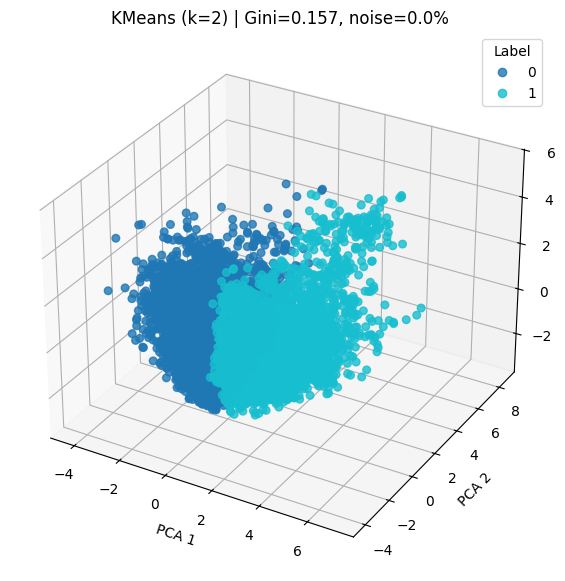

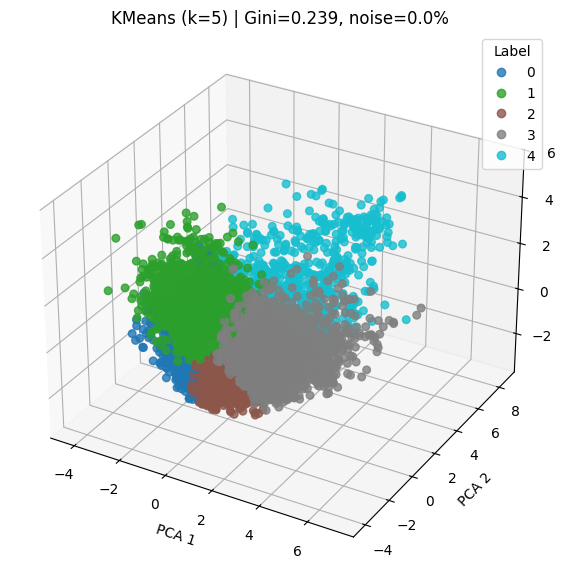

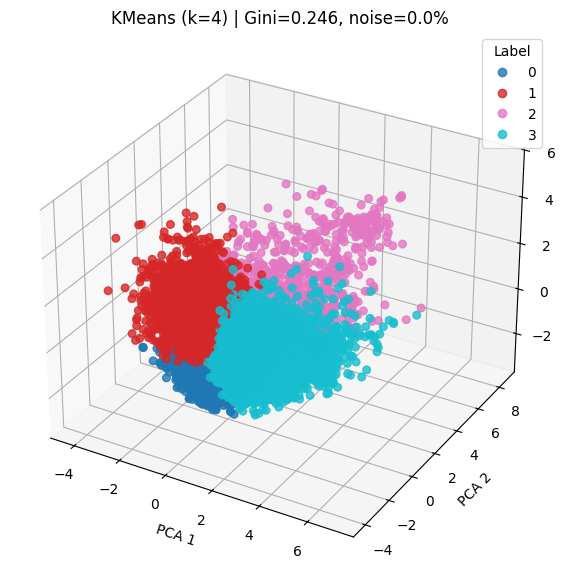

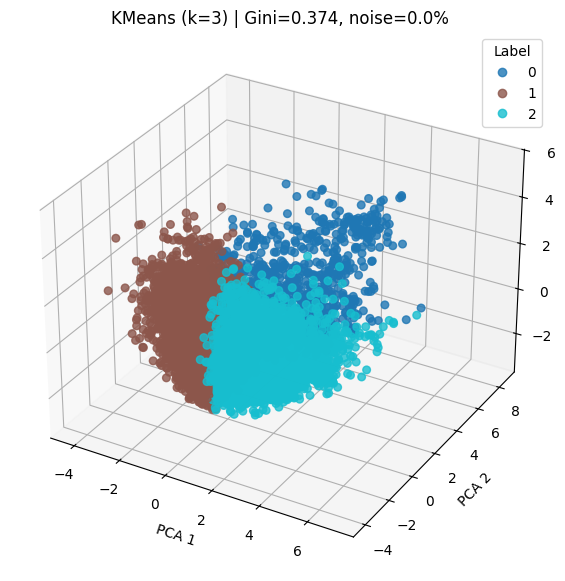

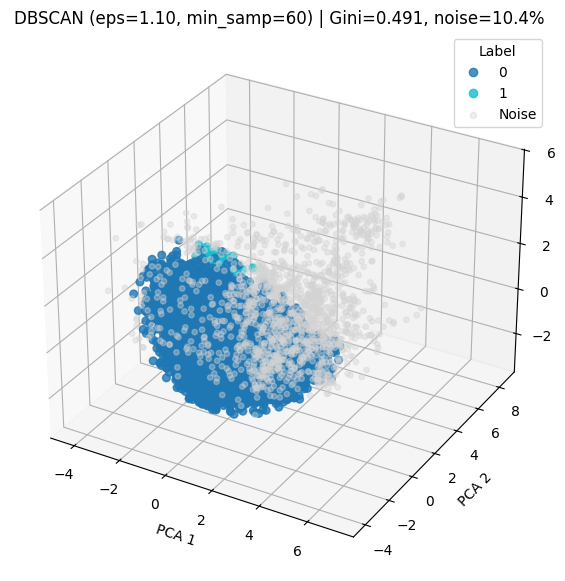

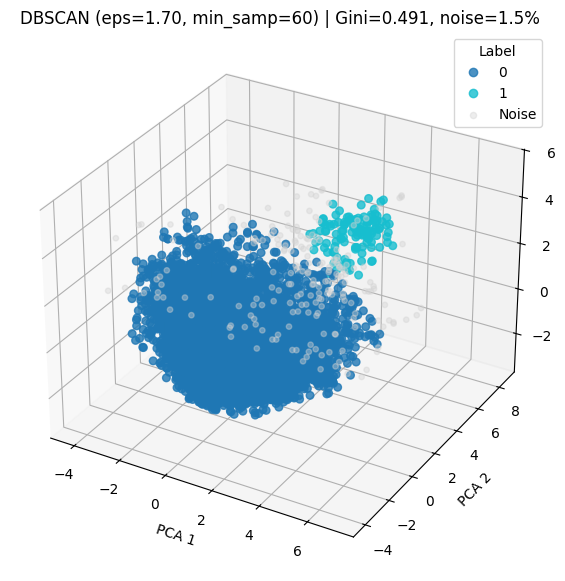

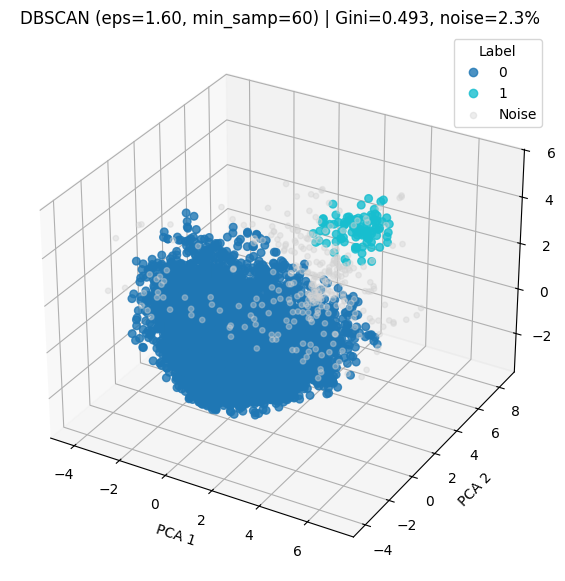

/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


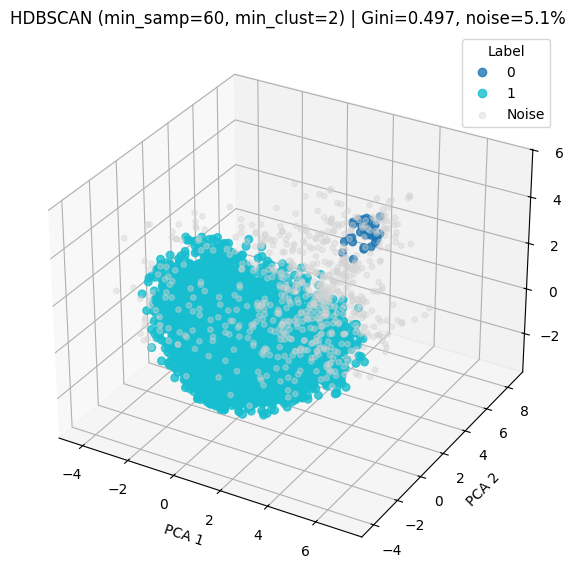

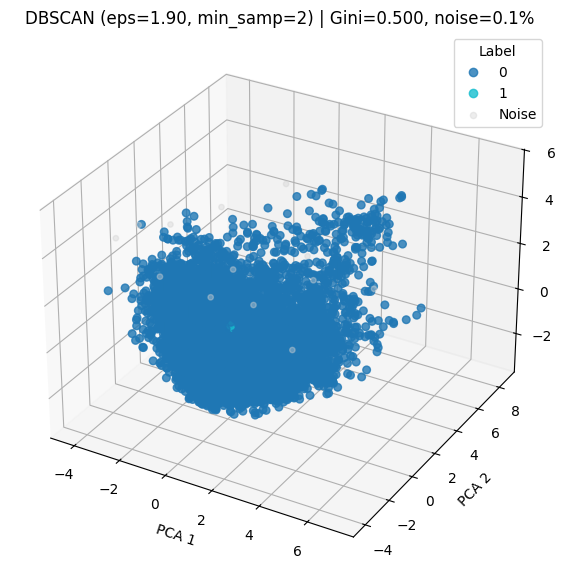

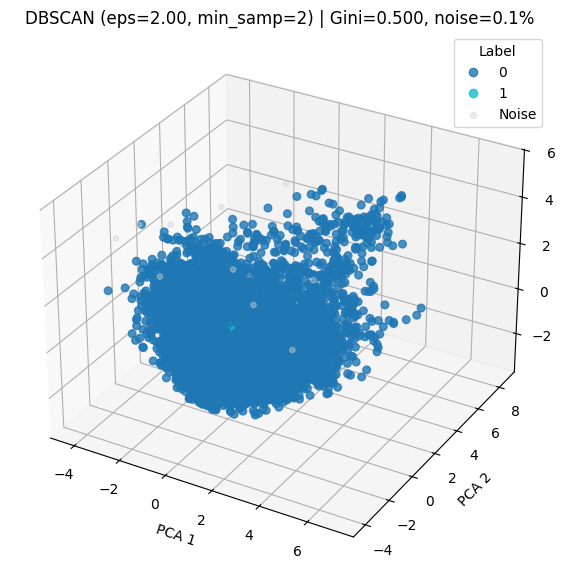

/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


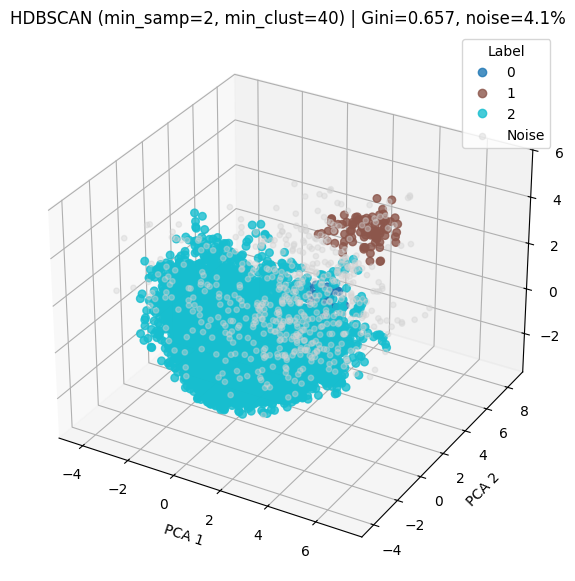

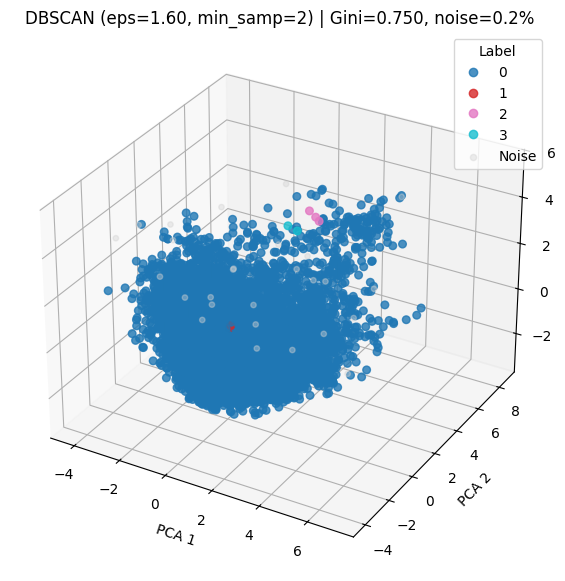

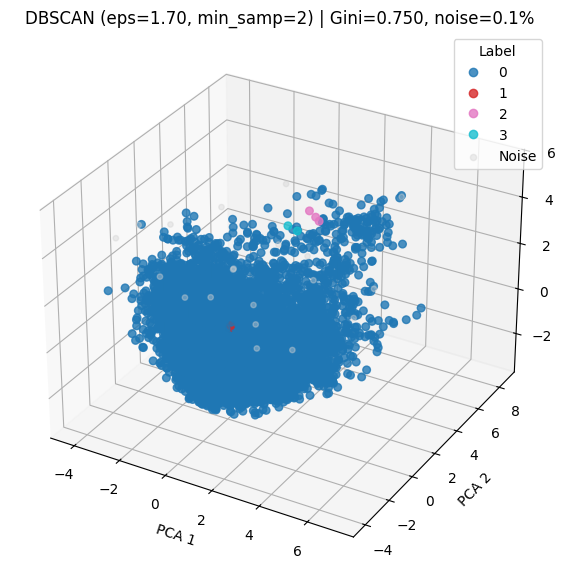

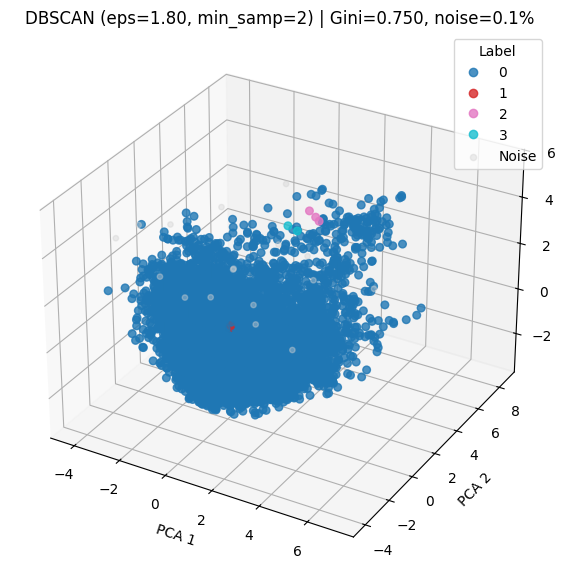

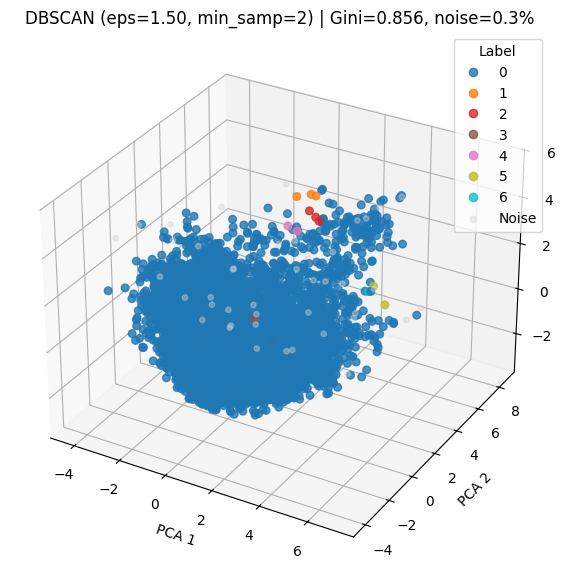

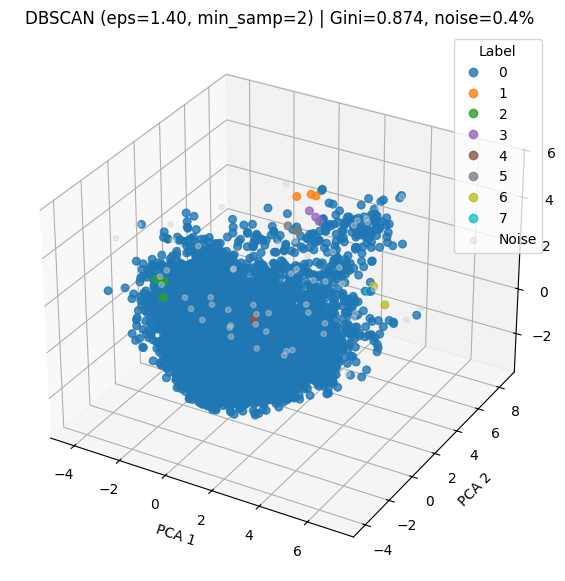

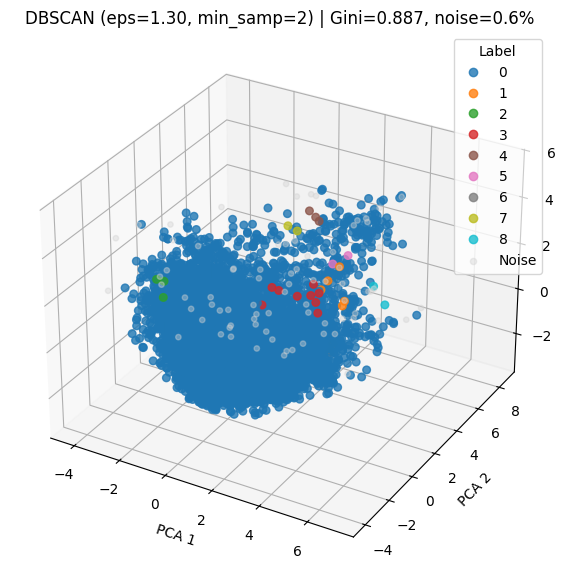

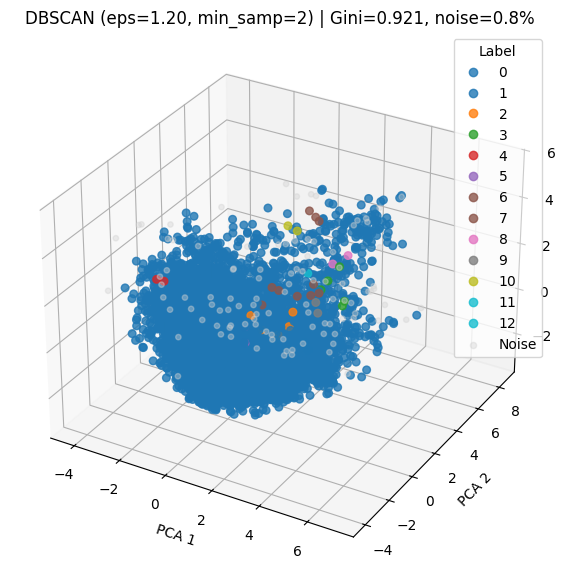

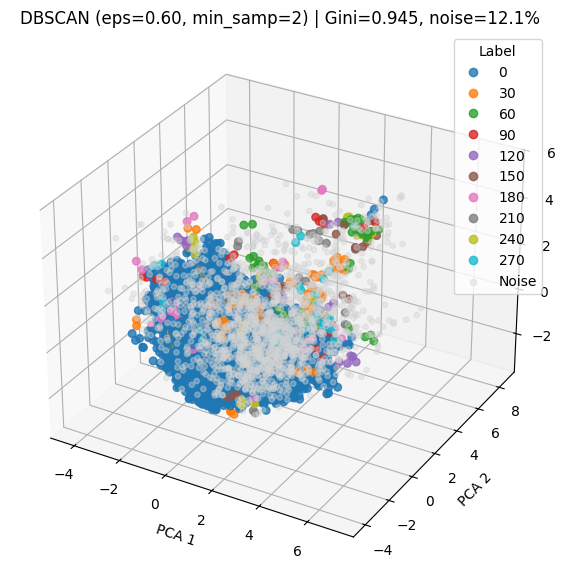

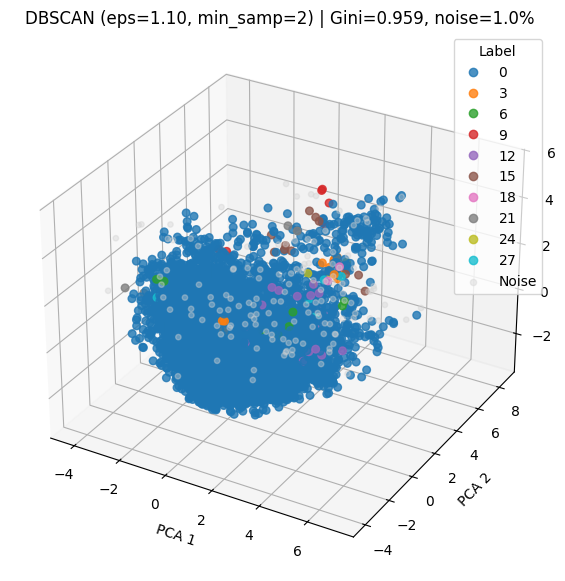

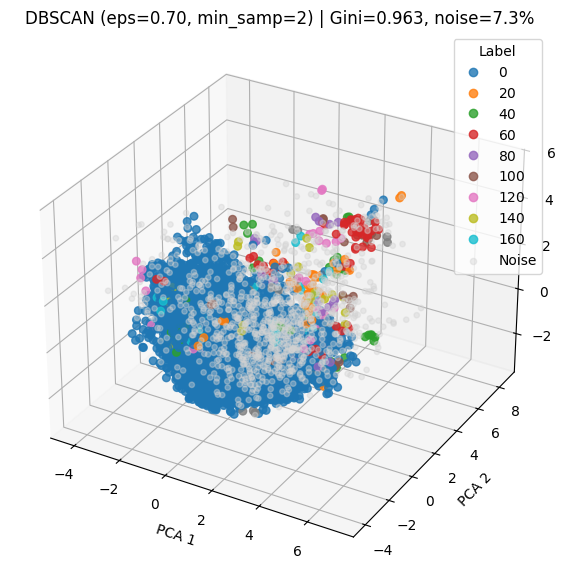

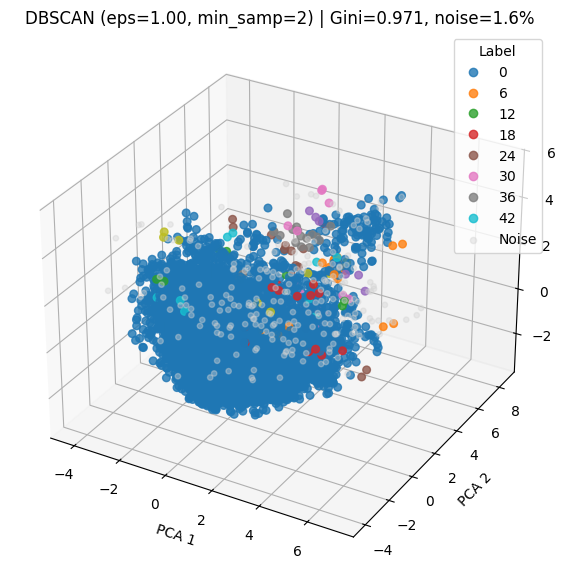

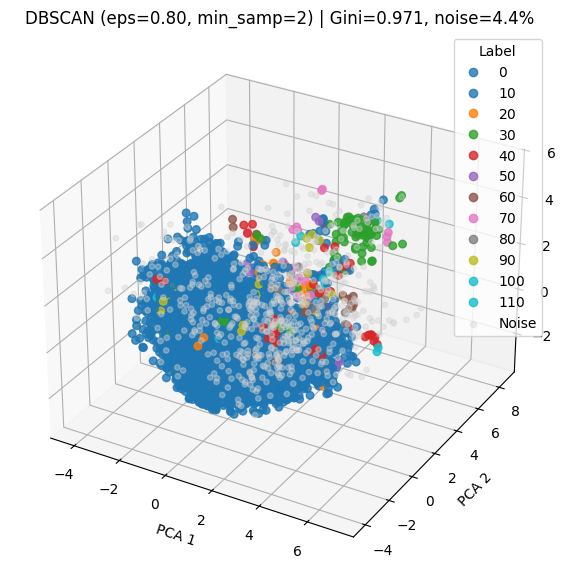

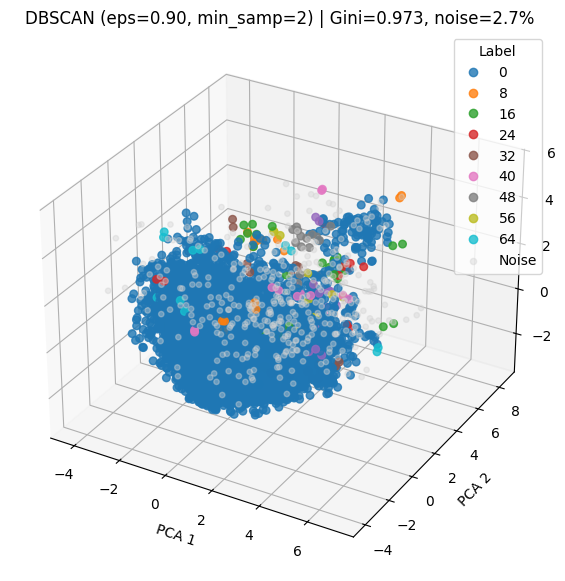

In [13]:
# Visualize every filtered clustering result in 3D PCA space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
pca_coords = pca.fit_transform(X_scaled)

for idx, row in filtered_results.iterrows():
    model_name = row['model']
    if model_name == 'kmeans':
        clusterer = KMeans(n_clusters=int(row['clust. #']), random_state=42)
        title = f"KMeans (k={int(row['clust. #'])})"
    elif model_name == 'dbscan':
        eps = row.get('HP (eps)')
        min_samp = row.get('HP (min_samp)')
        if pd.isna(eps) or pd.isna(min_samp):
            continue
        clusterer = DBSCAN(eps=float(eps), min_samples=int(min_samp), n_jobs=-1)
        title = f"DBSCAN (eps={float(eps):.2f}, min_samp={int(min_samp)})"
    elif model_name == 'hdbscan':
        min_samp = row.get('HP (min_samp)')
        min_clust = row.get('HP (min_clust)')
        if pd.isna(min_samp):
            continue
        min_clust_int = int(min_clust) if pd.notna(min_clust) else None
        clusterer = hdbscan.HDBSCAN(min_samples=int(min_samp),
                                    min_cluster_size=min_clust_int)
        min_clust_desc = f", min_clust={int(min_clust)}" if pd.notna(min_clust) else ''
        title = f"HDBSCAN (min_samp={int(min_samp)}{min_clust_desc})"
    else:
        continue

    labels = clusterer.fit_predict(X_scaled)
    core_mask = labels != -1
    noise_mask = labels == -1

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = None
    if core_mask.any():
        scatter = ax.scatter(
            pca_coords[core_mask, 0],
            pca_coords[core_mask, 1],
            pca_coords[core_mask, 2],
            c=labels[core_mask],
            cmap='tab10',
            s=30,
            alpha=0.8
        )

    if noise_mask.any():
        ax.scatter(
            pca_coords[noise_mask, 0],
            pca_coords[noise_mask, 1],
            pca_coords[noise_mask, 2],
            c='lightgray',
            s=15,
            alpha=0.4
        )

    ax.set_title(f"{title} | Gini={row['Gini']:.3f}, noise={row['noise %']:.1f}%")
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_zlabel('PCA 3')

    legend_handles = []
    legend_labels = []

    if scatter is not None:
        handles, labels_list = scatter.legend_elements()
        legend_handles.extend(handles)
        legend_labels.extend(labels_list)

    if noise_mask.any():
        noise_proxy = ax.scatter([], [], [], c='lightgray', s=20, alpha=0.4)
        legend_handles.append(noise_proxy)
        legend_labels.append('Noise')

    if legend_handles:
        ax.legend(legend_handles, legend_labels, title='Label')

    plt.show()
